## ТПР 11. Голотип-1
#### Козловский А.А., гр. 2253

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [8]:
df_train = pd.read_csv('CvsFiles/Holotype1TrainSet.csv')
df_test = pd.read_csv('CvsFiles/Holotype1TestSet.csv')

data_train = df_train.to_numpy(dtype=float)
data_test = df_test.to_numpy(dtype=float)

### Реализация необходимых функций

In [15]:
def get_similarity_measure(value1, value2, ex):
    """Функция для подсчета меры сходства двух объектов
    value1: значение свойства первого объекта
    value2: значение свойства второго объекта
    ex: экстримальная разность для рассматриваемого свойства
    returns: меру сходства"""
    return 1 - np.abs(value1 - value2) / ex

In [21]:
def build_similarity_matrix(data, feature_num):
    """Функция для построения матрицы сходства
    requirements: numpy
    data: значения свойств объектов [np.array]
    fearute_num: номер рассматриваемого свойства [int]
    returns: матрицу схожести [np.array]"""
    ex = np.max(data.T[feature_num]) - np.min(data.T[feature_num])
    result = np.zeros((data.shape[0], data.shape[0]))
    for i, value1 in enumerate(data.T[feature_num]):
        for j, value2 in enumerate(data.T[feature_num]):
            result[i, j] = get_similarity_measure(value1, value2, ex)
            
    return result

In [63]:
def build_avg_similarity_matrix(data):
    """Функция для построения средней матрицы схожести 
    по всем свойствам
    requirements: numpy
    data: матрица свойств объектов [np.array]
    returns: среднюю матрицу схожести [np.array]"""
    result = np.zeros((data.shape[0], data.shape[0]))
    
    for num, column in enumerate(data.T):
        result += build_similarity_matrix(data, num)
        
    result /= data.shape[1]
    return result

In [38]:
def get_average_similarity(similarity_matrix):
    """Функция для подсчёта средней меры сходства
    requirements: numpy
    similarity_matrix: матрица сходства [np.array]
    returns: среднюю меру сходства [float]"""
    r = similarity_matrix.shape[0]
    return (np.sum(similarity_matrix) - r) / (r * (r - 1))

In [108]:
def to_groups(similarity_matrix, bound):
    """Функция для распределения объектов по равномерным группам
    requirements: numpy
    similarity_matrix: матрица сходства [np.array]
    bound: нижний порог для отнесения объектов одной группе [float]
    returns: массив групп [np.array], каждая из которых [set]"""
    result = []
    for i in range(similarity_matrix.shape[0]):
        for j in range(i+1, similarity_matrix.shape[1]):
            if similarity_matrix[i, j] >= bound:
                done = False
                for s in result:
                    if i in s:
                        s.add(j)
                        done = True
                        break
                    elif j in s:
                        s.add(i)
                        done = True
                        break
                
                if not done:
                    result.append(set())
                    result[-1].add(i)
                    result[-1].add(j)
    
    return np.array(result)

In [311]:
def get_holotypes(similarity_matrix, sets):
    """Функция для нахождения голотипов групп
    requirements: numpy
    similarity_matrix: матрица сходства [np.array]
    sets: группы [np.array]
    returns: номера объектов-голотипов [np.array]"""
    result = np.zeros((sets.shape[0]), dtype=int)
    for num, set_ in enumerate(sets):
        max_sim = 0
        for i in set_:
            current_sum = np.sum([similarity_matrix[i, j] 
                              for j in set_])
            if max_sim < current_sum:
                max_sim = current_sum
                result[num] = i
                
    return result

In [312]:
def get_radiuses(similarity_matrix, sets, holotypes):
    """Функция для нахождения радусов групп
    requirements: numpy
    similarity_matrix: матрица сходств [np.array]
    sets: однородные группы [np.array]
    holotypes: голотипы групп [np.array]
    returns: массив радиусов групп [np.array]"""
    result = np.zeros(sets.shape)
    for num, set_ in enumerate(sets):
        result[num] = np.min([similarity_matrix[holotypes[num], i] 
                              for i in set_])
            
    return result

In [313]:
def test(holotypes, radiuses, test_data, exs):
    """Функция для распредления материала экзамена
    по однородным группам
    requirements: numpy
    holotypes: голотипы групп [np.array]
    radiuses: радиусы групп [np.array]
    test_data: материал экзамена [np.array]
    exs: экстримальные разности для свойств [np.array] 
    returns: вектор принадлежнасти к группам объектов
    материала экзамена [np.array]"""
    result = np.zeros((test_data.shape[0]), dtype=int)
    for num, values in enumerate(test_data):
        current = []
        for num_h, holotype in enumerate(holotypes):
            current.append(np.average([get_similarity_measure(holotype[i], value, exs[i]) / exs[i]
                                              for i, value in enumerate(values)]))
        result[num] = np.argmax(current)
        
    return result

In [314]:
similarity_matrix = build_avg_similarity_matrix(data_train)
average_similarity = get_average_similarity(similarity_matrix)

sets = to_groups(similarity_matrix, average_similarity + 0.2)

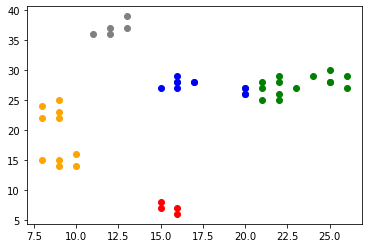

In [315]:
cmap = ['red', 'green', 'blue', 'gray', 'orange', 'black']
for k, s in enumerate(sets):
    plt.scatter([data_train.T[0][i] for i in s], [data_train.T[1][i] for i in s], color=cmap[k])
plt.show()

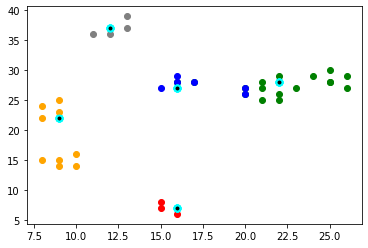

In [316]:
holotypes = np.array(get_holotypes(similarity_matrix, sets), dtype=int)
radiuses = get_radiuses(similarity_matrix, sets, holotypes)
for k, s in enumerate(sets):
    plt.scatter([data_train.T[0][i] for i in s], [data_train.T[1][i] for i in s], color=cmap[k])

    plt.scatter([data_train.T[0][i] for i in holotypes],
            [data_train.T[1][i] for i in holotypes],
            color='black', linewidths=2, edgecolors='cyan')
plt.show()

In [317]:
exs = np.array([np.max(data_test.T[i]) - np.min(data_test.T[i])
                for i in range(data_test.shape[1])])
holotypes_coordinates = np.array([data_train[num_h] for num_h in holotypes])
test_data_classes = test(holotypes_coordinates, radiuses, data_test, exs)

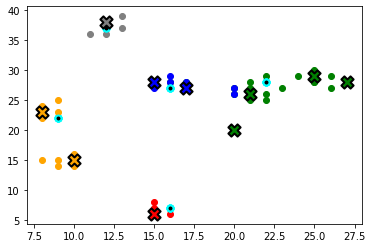

In [319]:
for k, s in enumerate(sets):
    plt.scatter([data_train.T[0][i] for i in s], [data_train.T[1][i] for i in s], color=cmap[k])

    plt.scatter([data_train.T[0][i] for i in holotypes],
            [data_train.T[1][i] for i in holotypes],
            color='black', linewidths=2, edgecolors='cyan')
    
for i, tds in enumerate(test_data_classes):
    plt.scatter(data_test[i][0], data_test[i][1], 
                color=cmap[tds], marker='X', s=150, edgecolors='black',
                linewidth=2)
plt.show()